## Segmentace CT snímků mozku pomocí Unet architektury
Jako poslední praktický příklad si ukážeme segmentaci CT símků mozku. Cílem tohoto příkladu je demonstrovat využití deep learning segmentaci medicínských snímků.
## Datová množina
Datová množina je obsažena v příloze v adresáři Brain_CT_dataset. Je organizována do dvou adresářů (in, out). V in adresáři se nachází 26 podadresářů, kde každý adresář obsahuje jeden CT sken mozku ve formě jednotlivých řezů, každý uložený v DICOM souboru. Adresář out má stejnou strukturu, jen místo DICOM souborů jsou řezy s označenými oblastmi uloženy v .png formátu.

Data jsou pořízena z CBF série pacientů získané mezi 2021-01-01 až 2021-02-01. K detekci a označení zájmových oblastí byl využit software InfarctionCoreDelineator s parametry c 7 7 1 0.3 0, kde c je CBV mapa (Cerebral Blood Volume), 7 je sousedství na ose x 7 pixelů,7 je sousedství na ose y 7 pixelů, 1 je sousedství na ose z 1 řez,  0.3 je úroveň prahu a 0 je polynomický stupeň aproximace [].

Skeny byly původně v jednom DICOM souboru, ale protože InfarctionCoreDelineator potřebuje na vstup sérii DICOM souborů, byl na transformaci 3D skenu na sérii 2D řezů použit software 3D Slicer, což je bezplatný software pro zpracování, vizualizaci a analýzu lékařských obrazových dat podporující vedle standardních formátů i mnoho formátů používaných v medicíně (např. DICOM, NIfTI či NRRD) [].

V 3D Sliceru se načetla série "CT Perfusion Stroke EnhCT CBFD" a následně pomocí pluginu Data->Export to DICOM->Scalar volume se vytvořila nová složka obsahující DICOM soubory jednotlivých řezů.

## Segmentace
Pro segmentaci se použije architektura Unet.

UNet je architektura neuronové sítě pro segmentaci obrazu. Tato architektura byla vyvinuta v roce 2015 pro biomedicínské aplikace, ale najde uplatnění i v jiných oblastech. UNet využívá tzv. "encoder-decoder" architekturu, která umožňuje efektivní využití informací z různých úrovní obrazu pro přesnější segmentaci.

In [1]:
# cesty k adresarum vsech skenu a masek
ct_scans = '/kaggle/input/ct-scans/in'
masks = '/kaggle/input/mask-scans/out'

In [2]:
import pydicom
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import gc
import cv2
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Concatenate, Input, Activation, BatchNormalization, Dropout, add
from keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPooling2D,  UpSampling2D
from keras.layers import Conv3D, Conv3DTranspose, MaxPooling3D, UpSampling3D
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import keras
os.environ['KMP_DUPLICATE_LIB_OK']='True'


gc.collect()

#Pouziti GPU-----
print(tf.test.gpu_device_name())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
#-----------------

#seznam k cest k adresarum jednotlivych skenu
scan_paths = sorted([os.path.join(os.getcwd(), ct_scans, x) for x in os.listdir(ct_scans)])
mask_paths = sorted([os.path.join(os.getcwd(), masks, x) for x in os.listdir(masks)])

print('CT scans->', str(len(scan_paths)))
print('Masks->', str(len(mask_paths)))

/device:GPU:0
CT scans-> 26
Masks-> 26


Musíme si definovat funkce, které nám budou načítat snímky ze souborů a transformovat je do polí, zároveň zde provedeme přeškálování rozměrů na jednu velikost a normalizaci hodnot.
U obrázků s vyznačenými oblastmi musíme ještě extrahovat samotnou oblast do podoby binárního snímku, kde oblast bude bílá a pozadí černé

In [3]:
# Funkce pro nacteni a ct skenu
# zaroven provede preskalovani obrazku na velikost img_size
# a zvysi kontrast pro lepsi segmentaci
def read_and_transform_dicom_scans(path, img_size):
    dicom_files= sorted(os.listdir(path))
    ct_scan = []
    for dicom_file in dicom_files:
        dicom_image = pydicom.read_file(path + '/' + dicom_file)
        array_image = dicom_image.pixel_array
        temp = Image.fromarray(array_image)
        resized_img = temp.resize((img_size, img_size))
        array_image = np.array(resized_img)
        array_image = array_image.astype(np.uint8)
        
        # zvyseni kontrastu podle doporucenych parametru
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        array_image = clahe.apply(array_image)
        ct_scan.append(array_image)        
    ct_scan = np.stack(ct_scan, axis=0)
    return ct_scan

# Funkce pro nacteni a png snimku s oznacenou oblasi zajmu skenu
# zaroven provede preskalovani obrazku na velikost img_size
# a extrahuje pouze binarni masku oblasti zajmu 
def read_and_transform_png_masks(path, img_size):
    mask_files= sorted(os.listdir(path))
    masks = []
    for i in range(len(mask_files)):
        mask_image = Image.open(path + '/DelineationSlice' + str(i) + '.png')
        mask_image = mask_image.resize((img_size, img_size))
        mask_image = mask_image.convert('RGB')
        white_image_mask = Image.new(mode='L', size=(img_size, img_size), color = 0)

        for x in range(img_size):
            for y in range(img_size):
                r, g, b = mask_image.getpixel((x, y))

                if r > g and r > b:
                    white_image_mask.putpixel((x, y), 255)

        white_image_mask = np.array(white_image_mask)
        white_image_mask = white_image_mask.astype(np.float64) / 255.0
        #----
        white_image_mask[white_image_mask > 0.5] = 1
        white_image_mask[white_image_mask <= 0.5] = 0
        #----
        masks.append(white_image_mask)

    masks = np.stack(masks, axis=0)
    return masks

Nyní načteme snímky a převedeme je do tenzorů s odpovídajícím tvarem (počet snímků, výška, šířka, )

In [4]:
from sklearn.model_selection import train_test_split
img_size = 256

#list 3D tenzoru (pocet rezu, vyska, sirka)
scans = [read_and_transform_dicom_scans(path, img_size) for path in scan_paths]
maskss = [read_and_transform_png_masks(path, img_size) for path in mask_paths]

# odstraneni nepotrebnych dat, kvuli omezene pridelene pameti v Kaggle notebooku
del scan_paths
del mask_paths

# Funkce vytvory 4D tenzory tvaru (pocet snimku, vyska, sirka, kanaly) ze vstupnich listu
def make_4D_tansors(scans, maskss):
    
    # tvorba 4D tenzorů tvaru (pocet snimku, vyska, sirka, kanaly)
    # protože tenzory v listu nemaji vsechny stejny tvar, nelze pouzit funkci np.stack
    # pro transformaci listu na tenzor
    ct_tensors = np.empty(shape=(0, 0, 0))
    mask_tensors = np.empty(shape=(0, 0, 0))

    ct_tensors = np.resize(ct_tensors, (0, img_size, img_size))
    mask_tensors = np.resize(mask_tensors, (0, img_size, img_size))

    for scan, mask in zip(scans, maskss):
        n = scan.shape[0]
        for i in reversed(range(n)):
            ct_tensors = np.insert(ct_tensors , 0, scan[i], axis=0)
            mask_tensors = np.insert(mask_tensors, 0, mask[i], axis=0)
    del scans
    del maskss
    
    # prida se dimenze pro pocet kanalu 
    mask_tensors = np.stack(mask_tensors, axis=0)
    mask_tensors = np.expand_dims(mask_tensors, axis=-1)
    ct_tensors = np.stack(ct_tensors, axis=0)
    ct_tensors = np.expand_dims(ct_tensors, axis=-1)
    
    # normalizace CT snimku (snimky masky neni treba normalizovat, obsahuji jen 0 nebo 1)
    mask = np.zeros_like(ct_tensors)
    
    # hodnoty, ktere jsou mensi nez 0 nebo vetsi nez 400 budou mit hodnotu 0
    # aby se zajistila rozumna normalizovana hodnota pro dulezite pixely
    for i in range(ct_tensors.shape[0]):
        slice_ = ct_tensors[i, :, :, 0]
        mask_slice = np.zeros_like(slice_)
        mask_slice[slice_ > 0] = 1
        mask_slice[slice_ < 0] = 0
        mask_slice[slice_ >= 750] = 0
        # binarni maska pro konkretni rez
        mask[i, :, :, 0] = mask_slice
    
    # nyni se ziskana binarni maska aplikuje na jednotlive CT rezy
    ct_scans_bg = np.abs(ct_tensors * mask)
    del ct_tensors
    # minimum a maximum pro normaizaci
    non_zero_mask = (ct_scans_bg != 0)
    min_val = np.min(ct_scans_bg[non_zero_mask])
    max_val = np.max(ct_scans_bg)

    # normalizace CT rezu jen pro neodfiltrovanou oblast mozku 
    ct_scans_norm = np.zeros_like(ct_scans_bg)
    ct_scans_norm[non_zero_mask] = (ct_scans_bg[non_zero_mask] - min_val) / (max_val - min_val)
    del ct_scans_bg
    del non_zero_mask
    print('Min value after normalization:', np.min(ct_scans_norm))
    print('Max value after normalization:', np.max(ct_scans_norm))
    
    return ct_scans_norm, mask_tensors

ct_scans_norm, mask_scans = make_4D_tansors(scans, maskss)

Min value after normalization: 0.0
Max value after normalization: 1.0


In [5]:
#funkce vyfiltruje jen snimky obsahujici pozitivni masky urcite velikosti a augmentuje je
def augment_positive_masked_slices(ct_tensors, mask_tensors, num_of_pos_pixels):
    loop = ct_tensors.shape[0]
    for i in range(loop):
        if np.sum(mask_tensors[i]) > num_of_pos_pixels:
            img, msk = rotation(ct_tensors[i,:,:,:], mask_tensors[i,:,:,:])
            ct_tensors = np.append(ct_tensors, img[np.newaxis,...], axis=0)
            mask_tensors = np.append(mask_tensors, msk[np.newaxis,...], axis=0)
            
            img, msk = transfation(ct_tensors[i,:,:,:], mask_tensors[i,:,:,:])
            ct_tensors = np.append(ct_tensors, img[np.newaxis,...], axis=0)
            mask_tensors = np.append(mask_tensors, msk[np.newaxis,...], axis=0)
            
            img, msk = scaling(ct_tensors[i,:,:,:], mask_tensors[i,:,:,:])
            ct_tensors = np.append(ct_tensors, img[np.newaxis,...], axis=0)
            mask_tensors = np.append(mask_tensors, msk[np.newaxis,...], axis=0)
    
    return ct_tensors, mask_tensors

# nahodna rotace
def rotation(image, mask):
    angle = np.random.randint(-75, 75)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows))
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    
    return image, mask

# nahodna translace
def transfation(image, mask):
    tx = np.random.randint(-25, 25)
    ty = np.random.randint(-25, 25)
    rows, cols = image.shape[:2]
    M = np.float64([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows))
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    
    return image, mask

# nahodne skalovani
def scaling(image, mask):
    scale = np.random.uniform(0.9, 1.5)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 0, scale)
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows))
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    
    return image, mask

augmented_cts, augmented_masks = augment_positive_masked_slices(ct_scans_norm, mask_scans, 50)
print(augmented_cts.shape)
print(augmented_masks.shape)
del ct_scans_norm
del mask_scans

(1602, 256, 256, 1)
(1602, 256, 256, 1)


In [6]:
# rozdeleni dat na tranovaci (80%) a validacni (20%)
train_ct, val_ct, train_mask, val_mask = train_test_split(augmented_cts, augmented_masks, test_size=0.2, random_state=42)
del augmented_cts
del augmented_masks
print(train_ct.shape)
print(val_ct.shape)
print(train_mask.shape)
print(val_mask.shape)

(1281, 256, 256, 1)
(321, 256, 256, 1)
(1281, 256, 256, 1)
(321, 256, 256, 1)


In [16]:
# definice nekolika ztratovych funkci a metrik
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def tversky_coef(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    intersection = K.sum(y_true_pos * y_pred_pos)
    diff1 = K.sum(y_true_pos * (1-y_pred_pos))
    diff2 = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.65
    beta = 1 - alpha
    return (intersection + smooth)/(intersection + alpha*diff1 + beta*diff2 + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def tversky_loss(y_true, y_pred):
    return 1 - tversky_coef(y_true, y_pred)

def focal_dice(y_true,y_pred):    
    d = dice_coef(y_true, y_pred)
    gamma = 0.95
    return K.pow((1-d), gamma)

def focal_tversky(y_true,y_pred):    
    t = tversky_coef(y_true, y_pred)
    gamma = 0.95
    return K.pow((1-t), gamma)

In [17]:
# Architektura Unet

def Unet(input_shape):
    inputs = Input(shape=input_shape)

    # vstupni blok
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    encoder_outputs = []
    previous_block_activation = x

    # Encoder (kontrakcni cesta)----------------------------------
    for filters in [64, 128]:
        for _ in range(2):
            x = SeparableConv2D(filters, 3, padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            
        encoder_outputs.append(x)    
        x = MaxPooling2D(3, strides=2, padding="same")(x)

        residual = Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = add([x, residual])
        previous_block_activation = x
        
    # Bottleneck (prechodova cesta)--------------------------------
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    for _ in range(2):
        x = SeparableConv2D(256, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    x = UpSampling2D(2)(x)
    
    # Decoder (expanzivni cesta)-----------------------------------
    for i, filters in enumerate([128, 64, 32]):
        for _ in range(2):
            x = Conv2DTranspose(filters, 3, padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
        
        x = UpSampling2D(2)(x)
            
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])
        previous_block_activation = x
        
        if i < len(encoder_outputs):
            enc_output = Conv2D(filters, 1, padding="same")(encoder_outputs[-i-1])
            x = Concatenate(axis=-1)([x, enc_output])

    # Vystupni vrstva
    outputs = Conv2D(1, 1, activation="sigmoid", padding="same", name="outputs")(x)
    
    return Model(inputs=[inputs], outputs=[outputs])



In [18]:
epochs = 35
batch_size = 32
input_shape=(256,256,1)
model = Unet(input_shape)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_tversky,metrics=[dice_coef, tversky_coef])
model.summary()
train_steps = len(train_ct) // batch_size
val_steps = len(val_ct) // (batch_size)

checkpoint = ModelCheckpoint('best_Unet_weights.hdf5' ,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )

callbacks_list = [checkpoint]

history = model.fit(train_ct,
                    train_mask,
                    steps_per_epoch=train_steps,
                    validation_data=(val_ct, val_mask),
                    validation_steps=val_steps,
                    callbacks=callbacks_list,
                    epochs=epochs,
                    verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 128, 128, 32  128        ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

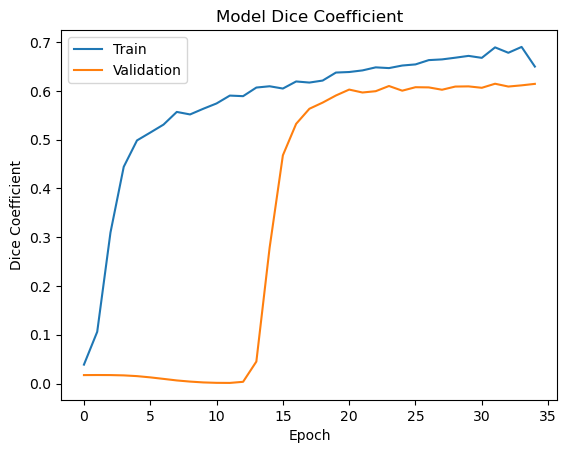

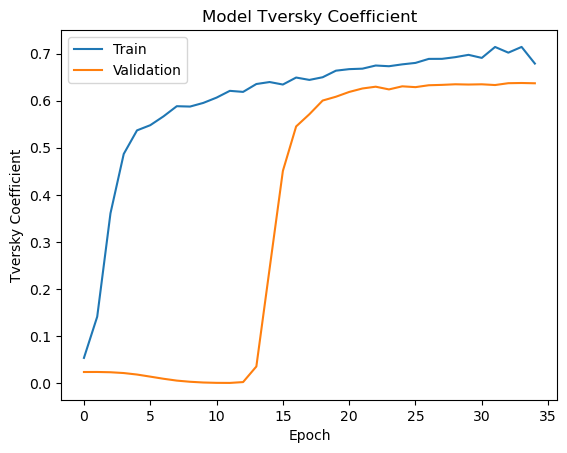

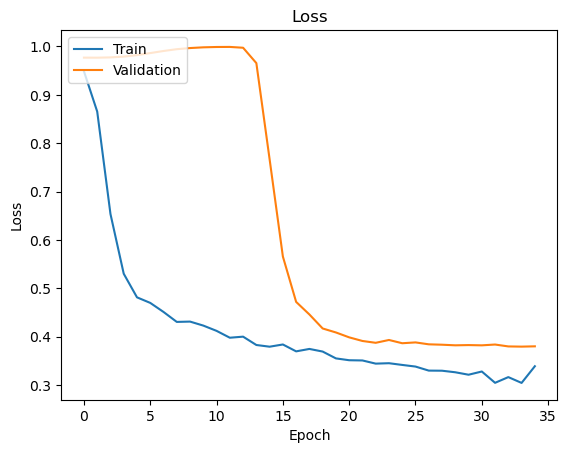

In [20]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['tversky_coef'])
plt.plot(history.history['val_tversky_coef'])
plt.title('Model Tversky Coefficient')
plt.ylabel('Tversky Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

11/11 [==============================] - 1s 111ms/step
(321, 256, 256, 1)


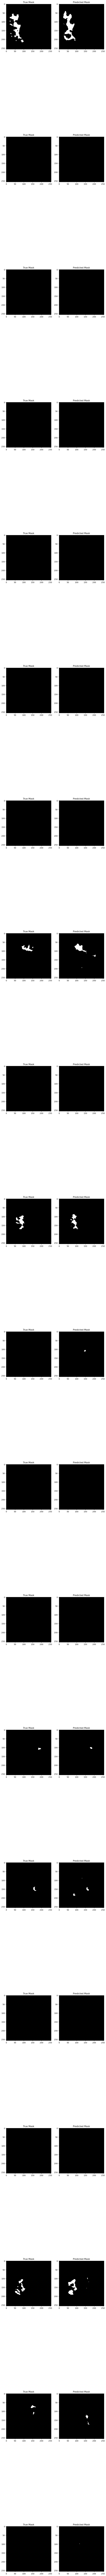

In [24]:
from random import random
from tensorflow.keras.models import load_model

# nacteni vah, ktere meli pri trenovani nejlepsi vzsledek na validacnich datech
model.load_weights('/kaggle/working/best_Unet_weights.hdf5')
predictions = model.predict(val_ct, verbose=1)
print(predictions.shape)

predictions = predictions.squeeze().round()

#vizualizace nekolika masek a k nim ucinenych predikci
fig, ax = plt.subplots(nrows=20, ncols=2, figsize=(8, 200))
for i in range(20):
    ax[i, 0].imshow(val_mask[i, :, :, :], cmap='gray')
    ax[i, 0].set_title('True Mask')
    
    ax[i, 1].imshow(predictions[i, :, :], cmap='gray')
    ax[i, 1].set_title('Predicted Mask')
    
plt.tight_layout()
plt.show()